In [2]:
import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from skimage import io
import os

from numba import cuda
import math
import requests

from queue import PriorityQueue

In [3]:
plotly.__version__
pio.renderers.default = "iframe"

In [4]:
np.__version__

'1.24.3'

In [5]:
np.random.seed(0)

In [6]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [7]:
%load_ext autoreload
%autoreload 2

from model import Bicycle, Map
from mppi import MPPI, MPPI_path_follower
from path_planner import a_star_planner
from sim import Simulation

import kmeans

In [8]:
torch.cuda.empty_cache() 

In [9]:
avoid = []

rect = [(20, 0, 80, 50),(20,51,80, 100) ]
circle= []

state_dim = 3
ctrl_dim = 2
u_min = (0., -4.)
u_max = (10., 4.)
step = .1
follow_depth = 8 # note: if these parameters are changed, the mppi ones should be changed to match
horizon_depth = 32

#start at 1-5, 45-55, angle -0

In [10]:

# avoid = []

# rect = [(0, 0, 100, 10),(0, 0, 10, 100), (0, 61, 85, 100), (20, 0, 100, 59),(95,0,100,100) ]
# circle= [(20,40, 6), (10, 30, 6),(10, 50, 6)]

# state_dim = 3
# ctrl_dim = 2
# u_min = (0., -5.)
# u_max = (10., 5.)
# step = .05
# follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
# horizon_depth = 64

# #start at (11-19, 11-19), angle math.pi/2

In [11]:
# avoid = []

# rect = [(0, 15, 47, 85), (53, 15, 100,85)]
# left_circles = [(47,20+x, 5) for x in range(0, 80, 20)]
# print(left_circles)
# right_circles = [(53,30+x, 5) for x in range(0, 60, 20)]
# circle= left_circles + right_circles

# state_dim = 3
# ctrl_dim = 2
# u_min = (0., -3.)
# u_max = (10., 3.)
# step = .05
# follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
# horizon_depth = 64

#start at (45-55, 1-5), angle math.pi/2

In [12]:
def get_expert_controls(control_history, horizon_depth, ctrl_dim, interval_start = 0, interval_end = None, interval_step=2, dev="cpu"):
    if(interval_end is None):
        interval_end = len(control_history)-1
    first_rollout = interval_start
    last_rollout = interval_end-horizon_depth
    
    rollout_starts = range(first_rollout, last_rollout+1, interval_step)
    size = len(rollout_starts)
    
    expert_controls = torch.empty([size, horizon_depth, ctrl_dim], dtype = torch.float, device = dev)
    count = 0
    for i in rollout_starts:
        expert_controls[count,:,:] = torch.stack(control_history[i:i+horizon_depth])        
        count+=1
    return expert_controls

In [13]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]

In [14]:
expert_controls = torch.tensor([],device = torch.device('cuda:0')) # used to reset expert_controls from constantly appending
a_star_sim = None
#
for i in range(10):
    for j in range(10):
        x = np.random.uniform(1, 5)
        y = np.random.uniform(45, 55)
        a_star_robot = Bicycle(x, y, 0, 0)
        goal = (90, 50, 1 , 10)

        mppi_sample_center= torch.tensor([0., 0.])
        mppi_sample_covariance = torch.tensor([[16.,0.],[0., 4.]])

        env = Map(goal_point = goal, avoidance_points=avoid, rect_obstacles=rect,circle_obstacles=circle, device = torch.device('cuda:0'))
        a_star_map = Map(goal_point = (a_star_robot.x, a_star_robot.y,4,4), speed_weight = 0.5, avoidance_points=avoid, 
                         rect_obstacles=rect,circle_obstacles=circle, device = torch.device('cuda:0'))

        def a_star_heuristic(state):     
            return env.terminal_state_cost_batch(state)

        a_star_plan = a_star_planner(a_star_robot, state_dim, ctrl_dim, u_min, u_max, 
                          env.get_obstacles_batch, env.get_distance_batch,
                         iterations = 50000, goal_point = env.goal_point, angle_density = 32, grid_interval = 0.5, goal_tolerance =0.1, 
                                           timestep = step, device=torch.device('cuda:0'))
        
        print (x, y, "plan ready")
        a_star_follower = MPPI_path_follower(a_star_robot, state_dim, ctrl_dim, 
                          mppi_sample_center, mppi_sample_covariance,  u_min, u_max, 
                          a_star_robot.dynamics_batch_horizon, a_star_map, 
                                             a_star_map.running_cost_batch_horizon, a_star_map.terminal_state_cost_batch, a_star_plan.path, 
                         num_samples = 8192, horizon = follow_depth, lambda_=5, sample_null_action = True,
                          timestep = step, device=torch.device('cuda:0'))
        print("expert demo started")
        
        a_star_sim = Simulation(a_star_robot, a_star_follower, a_star_map, goal_tolerance = 1, timestep = step)
        
        iter, goal_reached = a_star_sim.run(200, False, True, True, True, 
                                            write_rollout_start = 0, write_rollouts_num = 10, write_rate = 5)

        if not goal_reached:
            a_star_sim.display_history()
        else:
            #a_star_sim.display_run()
            #a_star_sim.display_history()
            new_controls = get_expert_controls(a_star_robot.control_history, horizon_depth, ctrl_dim,interval_step = 2, dev = torch.device('cuda:0'))
            
            #expert_means, assigned_num, loss = kmeans.k_means_segment(new_controls, k = 7)
            expert_controls = torch.cat((expert_controls, new_controls), 0)
    
            #expert_means[:, :, -1] = -expert_means[:, :, -1]
            new_controls[:, :, -1] = -new_controls[:, :, -1]
            expert_controls = torch.cat((expert_controls, new_controls), 0)

        
        # losses = []
        # clusters = []
        
        # for num_cluster in range(1, 50, 5):
        #     expert_means, assigned_num, loss = kmeans.k_means_segment(new_controls, k = num_cluster)
        #     losses.append(loss)
        #     clusters.append(num_cluster)
        # plt.plot(clusters, losses)
        # plt.show()
        
        print(expert_controls.shape)



201 32
3.195254015709299 52.151893663724195 plan ready
expert demo started
torch.Size([56, 32, 2])
201 32
3.4110535042865755 50.44883182996897 plan ready
expert demo started
torch.Size([112, 32, 2])
201 32
2.694619197355619 51.45894113066656 plan ready
expert demo started
torch.Size([168, 32, 2])
201 32
2.75034884505077 53.91773000782079 plan ready
expert demo started
torch.Size([226, 32, 2])
201 32
4.854651042004117 48.83441518825778 plan ready
expert demo started
torch.Size([282, 32, 2])
201 32
4.166900152330658 50.28894919752904 plan ready
expert demo started
torch.Size([338, 32, 2])
201 32
3.2721782443757292 54.25596638292661 plan ready
expert demo started
torch.Size([394, 32, 2])
201 32
1.2841442327915478 45.87129299701541 plan ready
expert demo started
torch.Size([454, 32, 2])
201 32
1.0808735897613029 53.32619845547938 plan ready
expert demo started
torch.Size([514, 32, 2])
201 32
4.1126270037994015 53.70012148246819 plan ready
expert demo started
torch.Size([570, 32, 2])
201 32

torch.Size([2104, 32, 2])
201 32
2.1312278503056383 46.20196561213169 plan ready
expert demo started
torch.Size([2162, 32, 2])
201 32
2.1845607900885797 46.18727718954244 plan ready
expert demo started
torch.Size([2220, 32, 2])
201 32
2.271932717575904 49.1426299451467 plan ready
expert demo started
torch.Size([2278, 32, 2])
201 32
1.2565899853951374 51.9247211937002 plan ready
expert demo started
torch.Size([2336, 32, 2])
201 32
3.2664058168263006 47.65389490939445 plan ready
expert demo started
torch.Size([2392, 32, 2])
201 32
3.0929922138667987 45.93940510758442 plan ready
expert demo started
torch.Size([2450, 32, 2])
201 32
3.303785982224717 54.29296197576214 plan ready
expert demo started
torch.Size([2508, 32, 2])
201 32
2.2742758098052946 51.67410379963682 plan ready
expert demo started
torch.Size([2566, 32, 2])
201 32
1.5271914496175687 52.16327204118566 plan ready
expert demo started
torch.Size([2624, 32, 2])
201 32
2.1576243717888044 46.83191362007117 plan ready
expert demo st

torch.Size([2740, 32, 2])
201 32
3.7112661471849204 47.70007973192165 plan ready
expert demo started
torch.Size([2796, 32, 2])
201 32
3.9407760884903795 54.62188545117438 plan ready
expert demo started
torch.Size([2852, 32, 2])
201 32
1.9950125740798321 50.761573344178366 plan ready
expert demo started
torch.Size([2910, 32, 2])
201 32
3.368167725087356 50.722519057908734 plan ready
expert demo started
torch.Size([2966, 32, 2])
201 32
1.8923265305624732 54.527490115169854 plan ready
expert demo started
torch.Size([3024, 32, 2])
201 32
2.7885015144705094 53.46408672471128 plan ready
expert demo started
torch.Size([3082, 32, 2])
201 32
3.7979171012700172 47.974369508551334 plan ready
expert demo started
torch.Size([3138, 32, 2])
201 32
4.255191278809908 48.965057408469846 plan ready
expert demo started
torch.Size([3194, 32, 2])
201 32
4.524412788444646 50.812728726358586 plan ready
expert demo started
torch.Size([3250, 32, 2])
201 32
4.526941447419411 51.92531590077766 plan ready
expert d

torch.Size([4726, 32, 2])
201 32
1.7999860995856003 45.18521794460614 plan ready
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([4726, 32, 2])
201 32
4.1747908134296825 47.2392468806038 plan ready
expert demo started
torch.Size([4782, 32, 2])
201 32
2.381406722787611 54.28081293465591 plan ready
expert demo started
torch.Size([4840, 32, 2])
201 32
3.817657607694131 45.318389295313075 plan ready
expert demo started
torch.Size([4898, 32, 2])
201 32
1.658776625991651 51.21478401499763 plan ready
expert demo started
torch.Size([4956, 32, 2])
201 32
3.3089143544166704 47.378928213745084 plan ready
expert demo started
torch.Size([5014, 32, 2])
201 32
4.736855991699175 51.13965955965896 plan ready
expert demo started
torch.Size([5068, 32, 2])
201 32
3.142531212099833 50.899099763545706 plan ready
expert demo started
torch.Size([5124, 32, 2])
201 32
3.9204881180670785 48.11944995479602 plan ready
expert demo started
torch.Size([5180, 32, 2])
201 32
2.5928842488643675 47.09843748975122 plan ready
expert demo started
torch.Size([5238, 32, 2])
201 32
1.7447720235213446 54.443723899839334 plan ready
expert demo 

In [15]:
# a_star_sim.draw_explored(a_star_plan.path, False)

# a_star_sim.display_run()
# a_star_sim.display_history()


1
11
21
31
41
51
61
71
81
91


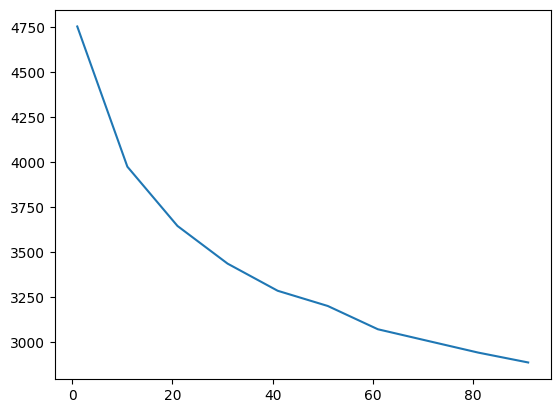

In [16]:
losses = []
clusters = []

for num_cluster in range(1, 101, 10):
    expert_means, assigned_num, loss = kmeans.k_means_segment(expert_controls, k = num_cluster)
    losses.append(loss)
    clusters.append(num_cluster)
    print(num_cluster)
plt.plot(clusters, losses)
plt.show()

In [40]:
num_clusters = 20
expert_means, assigned_to_center, loss = kmeans.k_means_segment(expert_controls, k = num_clusters)
print(assigned_to_center, expert_means.shape)


[97, 75, 93, 86, 518, 40, 516, 42, 506, 128, 484, 70, 528, 561, 27, 536, 105, 528, 477, 51] torch.Size([20, 32, 2])


In [45]:
use_expert_controls = False
samples = 2048
controls = None

expert_samples = [50 for i in range(20)]

if use_expert_controls:
    if expert_samples is not None:
        samples = samples
        controls = expert_means
    else:
        samples = samples - expert_controls.shape[0]
        controls = expert_controls
    
if(samples <0):
    print("too many expert rollouts")

In [46]:

mppi_sample_center= torch.tensor([0., 0.])
mppi_sample_covariance = torch.tensor([[16.,0.],[0., .11]])
# note: if these parameters are changed, the a-star ones should be changed to match

# changes to 8 clusters

success = 0.
total = 0.
total_it = 0.

for i in [1,  5]:
    for j in [45, 50, 55]:
        mppi_robot = Bicycle(i, j, 0, 0)
        mppi_goal = (90, 50, 3, 10)

        mppi_map = Map(goal_point = mppi_goal, avoidance_points=avoid, 
                       rect_obstacles=rect,circle_obstacles=circle, speed_weight = 0.1, device = torch.device('cuda:0'))
        mppi_controller = MPPI(mppi_robot, state_dim, ctrl_dim, 
                          mppi_sample_center, mppi_sample_covariance,  u_min, u_max,
                          mppi_robot.dynamics_batch_horizon, mppi_map.running_cost_batch_horizon, mppi_map.terminal_state_cost_batch,
                               expert_rollouts = controls, expert_samples = expert_samples,
                          num_samples = samples, horizon = horizon_depth, lambda_=.1,sample_null_action = True,
                          timestep = step, device=torch.device('cuda:0'))
        mppi_sim = Simulation(mppi_robot, mppi_controller, mppi_map, timestep = step, goal_tolerance = 2)

        iterations, completed = mppi_sim.run(iterations=300, draw_obstacles = False, write_snapshots =False, 
              write_rollouts=True, write_controls = True, write_rollout_start = 0, write_rollouts_num = 20,write_rate = 2)
        #mppi_sim.display_run()
        mppi_sim.display_history()
        print(i, j, completed, iterations)

        if completed:
            success+=1
            total_it += iterations
        total+=1
        
print(success/total)
if success > 0:
    print(total_it/success)



tensor([10000.], device='cuda:0')


1 45 False 300


1 50 True 98
tensor([10000.], device='cuda:0')


1 55 False 300
tensor([10000.], device='cuda:0')


5 45 False 300
tensor([10000.], device='cuda:0')


5 50 False 300
tensor([10000.], device='cuda:0')


5 55 False 300
0.16666666666666666
98.0
